In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%matplotlib inline

In [23]:
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks, activations, optimizers

In [24]:
from data_4_models import data_arrays, input_shape_check

In [25]:
x_train, y_train, x_valid, y_valid, x_test, y_test, alphabet = data_arrays(data_path= '/home/pgarcia/rbp_project/data/TIA1_K562_200.h5')
print(x_train.shape, y_train.shape)

(12663, 200, 9) (12663, 1)


In [26]:
x_train, x_test, x_valid = input_shape_check(x_train, x_test,x_valid)

Input shape adjusted:
(12663, 200, 4)
(3619, 200, 4)
(1808, 200, 4)


In [54]:
# Make an empty list that will contain index of all positive occurences in y_test
idx_ytest=[]

#use enumerate function to get index of positive signals in y_test
for i, entry in enumerate(y_test):
    if entry == 1:
        idx_ytest.append(i)

# Make an array from the list that contains all positive signals from y_test 
idx_ytest_array = np.array(idx_ytest)

# Get a random number from array by using numpy.random.choice()
random_num = np.random.choice(idx_ytest_array)

print(random_num)

1931


# DeepBind Model

In [55]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/deepbind + TIA1_K562_200.h5')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 200, 16)           1552      
                                                                 
 activation_2 (Activation)   (None, 200, 16)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 8, 16)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

(1, 200, 4)
tf.Tensor(
[[[ 2.44398005e-02 -1.99320644e-01 -1.98822245e-01  5.11542112e-02]
  [-3.15644979e-01  8.95274580e-02  1.37196392e-01 -2.41973817e-01]
  [-7.33219907e-02  4.54604477e-02 -8.23493302e-02 -2.33326346e-01]
  [ 8.84722322e-02 -1.14902388e-02 -1.12918578e-01  4.74697314e-02]
  [-4.90333587e-02 -1.96867704e-01  9.01331007e-02 -4.12444808e-02]
  [-1.51901543e-01  1.27646044e-01  3.31646428e-02 -1.67723566e-01]
  [-1.78172305e-01 -2.19150167e-02 -4.90009040e-02 -2.77942549e-02]
  [-6.55330867e-02  7.25261495e-02 -3.92944701e-02 -2.24889785e-01]
  [-2.13797763e-03 -5.55413514e-02  7.13146552e-02 -1.57974526e-01]
  [ 8.35412517e-02  2.59084068e-03 -1.49327833e-02 -3.89593631e-01]
  [ 5.51266074e-02 -2.59174183e-02 -6.11766428e-02  3.26359980e-02]
  [ 5.48671465e-04  6.86010271e-02 -1.00287572e-01 -2.86948085e-02]
  [-9.56187472e-02  1.64967939e-01  7.37847984e-02 -5.79085499e-02]
  [-3.35584819e-01 -1.70869291e-01  1.96705788e-01 -1.41315103e-01]
  [ 9.13666859e-02  3.426

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f90711686a0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f90710c73a0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

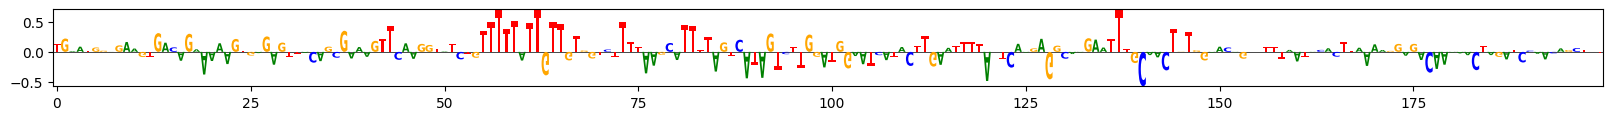

In [56]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[1931:1932]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f"TIA1_sal_map_seq1931_deepbind.svg", dpi=300)

# DeepBind_exp Model

In [57]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/deepbind_exp + TIA1_K562_200.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 16)           1552      
                                                                 
 activation (Activation)     (None, 200, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 16)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

(1, 200, 4)
tf.Tensor(
[[[ 1.87158724e-03 -3.29022966e-02  3.43501158e-02 -2.50678044e-03]
  [-5.99043034e-02 -1.99433994e-02 -8.85662343e-03  3.39163616e-02]
  [-6.99252933e-02  8.87990072e-02  3.52779850e-02 -4.89733554e-02]
  [ 8.04539919e-02  8.22506174e-02  7.78992847e-02  3.92898992e-02]
  [ 3.21181193e-02  1.26400262e-01  3.18367779e-01 -1.27396762e-01]
  [ 7.57354498e-03 -5.78995533e-02 -4.38194089e-02  2.42264420e-01]
  [ 5.19336835e-02  1.25546694e-01  7.08518177e-02 -2.55554169e-02]
  [ 1.05303667e-01  6.67447671e-02  9.16980505e-02 -2.30883099e-02]
  [-6.61086738e-02  1.50007516e-01  6.28491193e-02  4.54767011e-02]
  [-1.36562586e-01  9.90377516e-02  4.15027589e-02  2.62014568e-02]
  [-7.44729266e-02  1.09439820e-01  1.88508466e-01 -5.04313111e-02]
  [ 2.00720150e-02 -8.75600707e-03  1.67400166e-02  2.31754631e-01]
  [-8.68782476e-02  1.40481353e-01  1.96426526e-01 -1.26004592e-02]
  [ 2.81194560e-02  5.48882745e-02  9.07974551e-04  1.45430222e-01]
  [-8.48790556e-02  1.044

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f8fde04c340>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f8fde12e4f0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

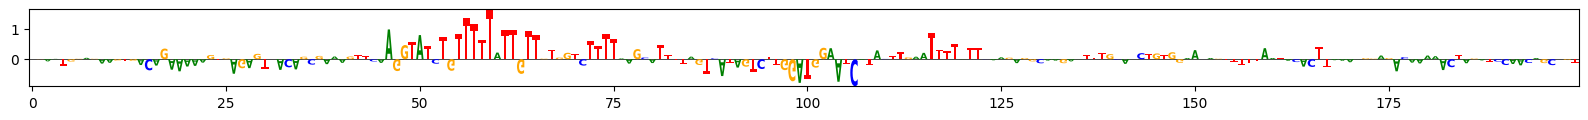

In [58]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[1931:1932]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f"TIA1_sal_map_seq1931_deepbind_exp.svg", dpi=300)

# Baseline CNN Model

In [60]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/baseline_cnn + TIA1_K562_200.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 30)           2310      
                                                                 
 activation (Activation)     (None, 200, 30)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 30)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 30)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 30)           17130     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 30)             0         
 g1D)                                                   

(1, 200, 4)
tf.Tensor(
[[[-8.91868234e-01 -6.64194703e-01 -8.68699908e-01 -1.66345403e-01]
  [-5.53411245e-01 -4.91015196e-01  1.41838133e-01 -6.94709182e-01]
  [ 9.43244025e-02 -1.82868481e-01 -5.12630343e-01 -6.09506488e-01]
  [ 2.15074867e-01 -5.17569363e-01 -1.04277945e+00  1.27013743e-01]
  [-5.27461290e-01 -3.28269541e-01 -1.14508361e-01 -2.42436767e-01]
  [-9.68958974e-01  1.31015167e-01  5.55552542e-02 -7.30399251e-01]
  [ 6.16759181e-01 -6.61416292e-01 -6.97230577e-01 -2.22580731e-01]
  [-1.71019062e-02 -3.18036526e-01 -1.41839013e-01 -4.28821534e-01]
  [-1.34891421e-01 -1.32197425e-01  4.62961912e-01 -8.59828413e-01]
  [ 7.25345075e-01 -6.10934258e-01 -5.25326073e-01 -6.75085336e-02]
  [ 1.21447362e-01  3.19724679e-02 -4.53913569e-01  1.22819543e-01]
  [-3.58640254e-01  1.31164759e-01  2.61351854e-01 -1.30136681e+00]
  [ 1.03932202e+00 -6.63157940e-01 -3.78863513e-01 -1.90341353e-01]
  [ 5.44723749e-01 -4.40807134e-01 -1.20248623e-01 -4.57027815e-02]
  [ 7.99105167e-01 -3.841

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f8fdde786a0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f8fdde78430>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

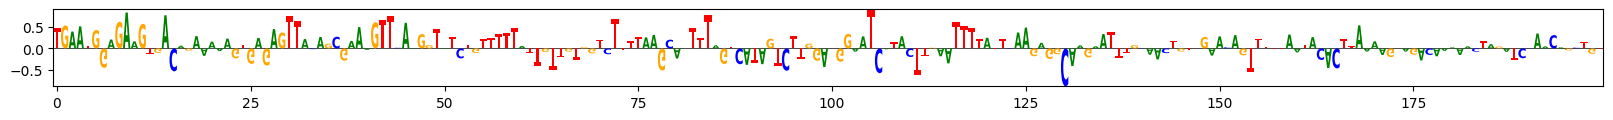

In [61]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[1931:1932]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f"TIA1_sal_map_seq1931_baseline_cnn.svg", dpi=300)

# Baseline_CNN_exp Model

In [62]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/baseline_cnn_exp + TIA1_K562_200.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 30)           2310      
                                                                 
 activation (Activation)     (None, 200, 30)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 30)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 30)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 30)           17130     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 30)             0         
 g1D)                                                   

(1, 200, 4)
tf.Tensor(
[[[-7.79506639e-02 -6.71135485e-02  3.60713333e-01  3.90349217e-02]
  [ 2.65829951e-01 -1.50496513e-01 -7.16214161e-03  1.81768835e-01]
  [-2.55888015e-01 -5.61199076e-02  2.39191845e-01  4.32209253e-01]
  [-2.48478070e-01 -2.64140815e-02  4.02013391e-01 -1.17592379e-01]
  [-1.30216032e-02 -3.22969705e-02  9.18244049e-02 -8.59282836e-02]
  [-3.06344986e-01  1.96958303e-01 -1.57818779e-01  3.33124280e-01]
  [ 6.83872700e-02  3.49823199e-02  3.30269616e-03 -8.48052930e-03]
  [-2.08321780e-01 -1.53065044e-02  3.55303168e-01  9.59903151e-02]
  [-1.18669495e-01  4.09373224e-01 -1.33755684e-01  3.95365387e-01]
  [-1.83509707e-01  5.42219043e-01  4.52100746e-02  1.05307288e-02]
  [-6.05914369e-02 -2.40188316e-02  4.51591194e-01  7.23408759e-02]
  [-9.14375260e-02 -1.44658864e-01  2.20275462e-01  2.71234781e-01]
  [-1.03868425e-01 -9.43615437e-02  4.43671554e-01 -5.11537753e-02]
  [-2.11516112e-01  3.89550105e-02  3.30348253e-01 -3.69341671e-03]
  [-1.51586086e-01 -7.499

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f8fde23ba90>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f8fde23b9a0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

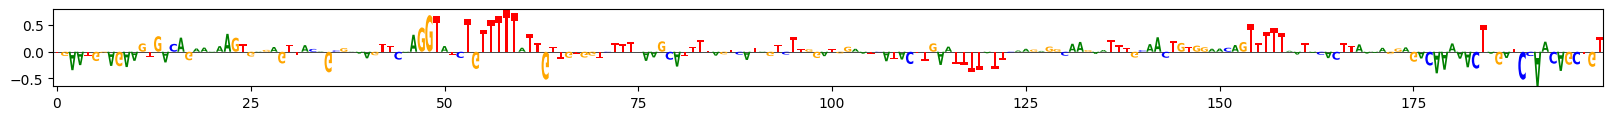

In [63]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[1931:1932]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f"TIA1_sal_map_seq1931_baseline_cnn_exp.svg", dpi=300)